In [4]:
import os
import h5py
from PIL import Image
import numpy as np

filename = os.path.expanduser("~/LLaVA/armbench512x384_5_all.h5")
# filename = "armbench512x384_5_all.h5"
f = h5py.File(filename, "r")
print(f["data"].shape)
i = 614*32+16
img = Image.fromarray(f["data"][i])
mask = f["mask"]

boxes = []
for cat in np.unique(mask[i]):
    if cat == 0 or cat == 255:
        continue
    mask_i = mask[i]
    mask_i = mask_i == cat
    bbox = {
        "bbox": [
            int(np.min(np.where(mask_i)[1])),  # x
            int(np.min(np.where(mask_i)[0])),  # y
            int(np.max(np.where(mask_i)[1]))
            - int(np.min(np.where(mask_i)[1])),  # width
            int(np.max(np.where(mask_i)[0]))
            - int(np.min(np.where(mask_i)[0])),  # height
        ],
        "labels": cat,
    }
    boxes.append(bbox)

print(boxes)
img.save('armbench/images/828.jpg')

(62278, 384, 512, 3)
[{'bbox': [61, 65, 262, 262], 'labels': 1}]


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_bbox(image, data):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data["bboxes"], data["labels"]):
        # Unpack the bounding box coordinates
        x1, y1, w, h = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x1, y1), w, h, linewidth=3, edgecolor='y', facecolor="none"
        )
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(
            x1,
            y1,
            label,
            color="white",
            fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5),
        )

    # Remove the axis ticks and labels
    ax.axis("off")

    # Show the plot
    plt.show()

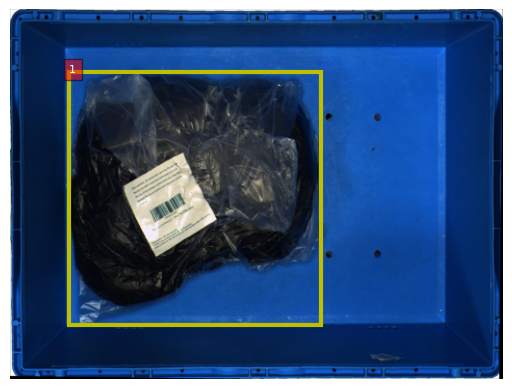

In [7]:
plot_bbox(img, {"bboxes": [b["bbox"] for b in boxes], "labels": [b["labels"] for b in boxes]})

In [3]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

model_path = "/home/zanqi/LLaVA/llava/checkpoints/llava-v1.5-7b-task-lora"
model_base = "liuhaotian/llava-v1.5-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=model_base,
    model_name=get_model_name_from_path(model_path)
)

/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading LLaVA from base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...


/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Model is loaded...


/home/zanqi/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
model_path = "/home/zanqi/LLaVA/llava/checkpoints/llava-v1.5-7b-task-lora"
model_base = "liuhaotian/llava-v1.5-7b"

get_model_name_from_path(model_path)

'llava-v1.5-7b-task-lora'

In [15]:
model_path, model_base

('/home/zanqi/LLaVA/llava/checkpoints/llava-v1.5-7b-task-lora',
 'liuhaotian/llava-v1.5-7b')

In [17]:
prompt = "What are the things I should be cautious about when I visit here?"
image_file = "https://llava-vl.github.io/static/images/view.jpg"

args = type('Args', (), {
    "model_path": model_path,
    "model_base": model_base,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512
})()

eval_model(args)

Loading LLaVA from base model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...


AssertionError: 